In [1]:
from mylib.statistic_test import *

code_id = "0853 - Diverge of Route 7 Map"
loc = os.path.join(figpath, "Dsp", code_id)
mkdir(loc)

from mylib.statistic_test import *
from mazepy.datastruc.neuact import SpikeTrain, TuningCurve, NeuralTrajectory
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

dir_name1 = join(figpath, "Dsp", "0850 - Lisa Paper Revisits")
dir_name0 = join(figpath, "Dsp", "0844 - Manifold of Initialization")

def get_transient_map(mouse: int):
    """
    Get Final Maps and Information
    """
    if exists(join(dir_name1, f"transient_{mouse}.pkl")):
        with open(join(dir_name1, f"transient_{mouse}.pkl"), "rb") as f:
            return pickle.load(f)
    else:
        raise FileNotFoundError(
            f"Please run Fig0850 - Lisa Paper Revisits.ipynb first "
            f"to generate transient_{mouse}.pkl"
        )

from umap.umap_ import UMAP
from matplotlib import cm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN, KMeans
import hdbscan

def counts(mouse: int):
    with open(join(dir_name0, f"{mouse}.pkl"), 'rb') as handle:
        _, session_traj, _, _, route_traj, lap_traj, pos_traj, speed_traj, _, _, _, _, _, neural_traj = pickle.load(handle)

    #bins = np.concatenate([Father2SonGraph[i] for i in np.setdiff1d(CP_DSP[6], CP_DSP[3])])
    idx = np.where(
        #(np.isin(pos_traj, bins-1)) &
        (np.isin(route_traj, [0, 1, 2, 3, 4, 5, 6]))
    )[0]
    
    D = GetDMatrices(1, 48)
    dist_traj = D[pos_traj, 2303]
    
    with open(join(loc, f"{mouse}.pkl"), "wb") as f:
        pickle.dump([
            neural_traj, 
            session_traj, 
            route_traj, 
            lap_traj, 
            pos_traj, 
            speed_traj
        ], f)

def get_data(mouse):
    """All Data"""
    if exists(join(loc, f"{mouse}.pkl")) == False:
        counts(mouse)
        
    with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
        return pickle.load(handle)

        E:\Data\FinalResults\Dsp\0853 - Diverge of Route 7 Map is already existed!


TtestResult(statistic=-8.359284164017584, pvalue=7.44923942766484e-11, df=47)
TtestResult(statistic=2.48383109399817, pvalue=0.014105192395863839, df=149)
Ttest_indResult(statistic=-0.8289660409693154, pvalue=0.40813199882104045)
Ttest_indResult(statistic=9.340770047223776, pvalue=2.160773872803888e-17)
48
48
150
150


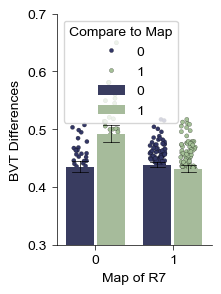

In [ ]:
def get_fate(mouse: int):
    (
        kmeans_dist_traj2, 
        neural_traj2, 
        session_traj2, 
        old_pos_traj2, 
        route_traj2, 
        lap_traj2, 
        pos_traj2, 
        speed_traj2,
        dists
    ) = get_transient_map(mouse)
    
    beg2 = np.concatenate([[0], np.where(np.ediff1d(lap_traj2) != 0)[0]+1])
    end2 = np.concatenate([np.where(np.ediff1d(lap_traj2) != 0)[0]+1, [lap_traj2.shape[0]]])

    median_kmean_dists = np.zeros(beg2.shape[0])
    for i in range(beg2.shape[0]):
        median_kmean_dists[i] = np.nanmean(kmeans_dist_traj2[beg2[i]:end2[i]])

    labels = np.where(median_kmean_dists > 0, 0, 1)
    return median_kmean_dists, labels

def get_lap_information(mouse: int):
    if exists(join(loc, f" {mouse}_behav.pkl")):
        with open(join(loc, f"{mouse}_behav.pkl"), 'rb') as handle:
            return pickle.load(handle)
    
    print(mouse)
    median_kmean_dists, lap_labels = get_fate(mouse)
    
    traces = []
    for i in tqdm(np.where(f2['MiceID'] == mouse)[0]):
        with open(f2['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
        traces.append(trace)
        
    with open(f_CellReg_dsp['cellreg_folder'][np.where(f_CellReg_dsp['MiceID'] == mouse)[0][0]], 'rb') as handle:
        index_map = pickle.load(handle)
    
        if mouse != 10232:
            index_map = index_map[1:, :]
    
        index_map = index_map.astype(np.int64)
        
    behav_trajs = []
    pos_trajs = []
    route_trajs = []
    lap_trajs = []
    session_trajs = []
    time_trajs = []
    speed_trajs = []
    len_trajs = []
    
    for s, trace in tqdm(enumerate(traces)):
        # Get Lapwise Information
        beg_time, end_time = trace['lap beg time'], trace['lap end time']
        beg, end = LapSplit(trace, trace['paradigm'])
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)

        for i in range(beg.shape[0]):
            if trace['is_perfect'][i] != 1:
                continue
        
            # Behavior Vectors:
            # [
            #   [x],
            #   [y],
            #   [vx],
            #   [vy]
            # ]
            pos = trace['correct_pos'][beg[i]:end[i]+1]
            x, y = pos[:, 0], pos[:, 1]
            dx, dy = np.append(np.ediff1d(x), 0), np.append(np.ediff1d(y), 0)
            dl = np.sqrt(dx**2 + dy**2)
            dt = np.append(np.ediff1d(trace['correct_time'][beg[i]:end[i]+1]), 50)
            vx, vy = dx/dt, dy/dt
            theta = np.arctan2(vy, vx)
        
            behav_traj = np.vstack([x, y, vx, vy])
            lap_traj = np.repeat(i, behav_traj.shape[1])
            route_traj = np.repeat(routes[i], behav_traj.shape[1])
            session_traj = np.repeat(s, behav_traj.shape[1])
            pos_traj = trace['correct_nodes'][beg[i]:end[i]+1]-1
            speed_traj = np.sqrt(vx**2 + vy**2)
            len_traj = np.concatenate([[0], np.cumsum(dl)[:-1]])
            time_traj = np.concatenate([[0], np.cumsum(dt)[:-1]])
            
            behav_trajs.append(behav_traj)
            lap_trajs.append(lap_traj)
            route_trajs.append(route_traj)
            session_trajs.append(session_traj)
            pos_trajs.append(pos_traj)
            time_trajs.append(time_traj)
            speed_trajs.append(speed_traj)
            len_trajs.append(len_traj)
    
    behav_trajs = np.concatenate(behav_trajs, axis=1)
    lap_trajs = np.concatenate(lap_trajs)
    route_trajs = np.concatenate(route_trajs)
    session_trajs = np.concatenate(session_trajs)
    pos_trajs = np.concatenate(pos_trajs)
    time_trajs = np.concatenate(time_trajs)
    speed_trajs = np.concatenate(speed_trajs)
    len_trajs = np.concatenate(len_trajs)
    
    map_trajs = np.zeros(behav_trajs.shape[1], np.int64)
    beg = np.concatenate([[0], np.where(np.ediff1d(lap_trajs) != 0)[0]+1])
    end = np.concatenate([np.where(np.ediff1d(lap_trajs) != 0)[0]+1, [lap_trajs.shape[0]]])
    for i in range(beg.shape[0]):
        map_trajs[beg[i]:end[i]] = lap_labels[i]
        
    with open(join(loc, f"{mouse}_behav.pkl"), "wb") as f:
        pickle.dump([
            behav_trajs.astype(np.float64), 
            lap_trajs.astype(np.int64), 
            route_trajs.astype(np.int64), 
            session_trajs.astype(np.int64), 
            pos_trajs.astype(np.int64), 
            time_trajs.astype(np.float64),
            speed_trajs.astype(np.float64),
            len_trajs.astype(np.float64),
            map_trajs.astype(np.int64)
        ], f)
        
    with open(join(loc, f"{mouse}_behav.pkl"), 'rb') as handle:
        return pickle.load(handle)

from scipy.spatial.distance import cdist
def calc_traj_distances(traj1, traj2):
    if traj1.shape[0] < traj2.shape[0]:
        traj1, traj2 = traj2, traj1
    
    pairwise_dist = cdist(traj1, traj2)
    
    return np.mean(np.min(pairwise_dist, axis=0))
    

if exists(join(figdata, f"{code_id} [Behav].pkl")) == False:
    Data = {
        "MiceID": [],
        "Session": [],
        "Compare to Map": [],
        "Map of R7": [],
        "BVT Differences": [],
    }

    for mouse in [10212, 10224, 10227, 10232]:

        (
            behav_traj, 
            lap_traj, 
            route_traj, 
            session_traj, 
            pos_traj, 
            time_traj,
            speed_traj,
            len_traj,
            map_traj
        ) = get_lap_information(mouse)

        idx = np.where(np.isin(S2F[pos_traj], CP_DSP[3]))[0]

        behav_traj = behav_traj[:, idx]
        behav_traj = (behav_traj - np.mean(behav_traj, axis=1, keepdims=True)) / np.std(behav_traj, axis=1, keepdims=True)
        lap_traj = lap_traj[idx]
        route_traj = route_traj[idx]
        session_traj = session_traj[idx]
        pos_traj = pos_traj[idx]
        time_traj = time_traj[idx]
        speed_traj = speed_traj[idx]
        len_traj = len_traj[idx]
        map_traj = map_traj[idx]
        
        beg = np.concatenate([[0], np.where(np.ediff1d(lap_traj) != 0)[0]+1])
        end = np.concatenate([np.where(np.ediff1d(lap_traj) != 0)[0]+1, [lap_traj.shape[0]]])
        
        behav_sep = [
            behav_traj[:, beg[i]:end[i]] for i in range(beg.shape[0])
        ]
        lap_sep = lap_traj[beg]
        route_sep = route_traj[beg]
        session_sep = session_traj[beg]
        map_sep = map_traj[beg]
        
        dist_mat = np.zeros((beg.shape[0], beg.shape[0])) * np.nan
        
        for i in range(beg.shape[0]-1):
            for j in range(i+1, beg.shape[0]):
                dist_mat[i, j] = calc_traj_distances(behav_sep[i].T, behav_sep[j].T)
                dist_mat[j, i] = dist_mat[i, j]
        
        for s in tqdm(range(7)):
            ref0_idx = np.where((map_sep == 0)&(session_sep == s)&(route_sep != 6))[0]
            ref1_idx = np.where((map_sep == 1)&(session_sep == s)&(route_sep != 6))[0]
            
            r7_with_map0_idx = np.where((map_sep == 0)&(session_sep == s)&(route_sep == 6))[0]
            r7_with_map1_idx = np.where((map_sep == 1)&(session_sep == s)&(route_sep == 6))[0]
            
            r7_with_map0_dist_to_map0 = dist_mat[np.ix_(ref0_idx, r7_with_map0_idx)]
            r7_with_map0_dist_to_map1 = dist_mat[np.ix_(ref1_idx, r7_with_map0_idx)]
            r7_with_map1_dist_to_map0 = dist_mat[np.ix_(ref0_idx, r7_with_map1_idx)]
            r7_with_map1_dist_to_map1 = dist_mat[np.ix_(ref1_idx, r7_with_map1_idx)]
            
            ctrl_to_map0 = np.nanmean(dist_mat[np.ix_(ref0_idx, ref1_idx)], axis=0)
            ctrl_to_map1 = np.nanmean(dist_mat[np.ix_(ref1_idx, ref0_idx)], axis=0)
            
            r7_with_map0_dist_to_map0 = np.nanmean(r7_with_map0_dist_to_map0, axis=0)
            r7_with_map0_dist_to_map1 = np.nanmean(r7_with_map0_dist_to_map1, axis=0)
            r7_with_map1_dist_to_map0 = np.nanmean(r7_with_map1_dist_to_map0, axis=0)
            r7_with_map1_dist_to_map1 = np.nanmean(r7_with_map1_dist_to_map1, axis=0)
            
            Data["MiceID"].append(np.repeat(
                mouse, 
                (
                    r7_with_map0_dist_to_map0.shape[0] + 
                    r7_with_map1_dist_to_map0.shape[0] + 
                    r7_with_map0_dist_to_map1.shape[0] + 
                    r7_with_map1_dist_to_map1.shape[0] +
                    ctrl_to_map0.shape[0] + 
                    ctrl_to_map1.shape[0]
                )
            ))
            Data["Session"].append(np.repeat(
                s, 
                (
                    r7_with_map0_dist_to_map0.shape[0] + 
                    r7_with_map1_dist_to_map0.shape[0] + 
                    r7_with_map0_dist_to_map1.shape[0] + 
                    r7_with_map1_dist_to_map1.shape[0] +
                    ctrl_to_map0.shape[0] + 
                    ctrl_to_map1.shape[0]
                )
            ))
            Data["Compare to Map"].append(np.concatenate([
                np.repeat(0, r7_with_map0_dist_to_map0.shape[0]),
                np.repeat(0, r7_with_map1_dist_to_map0.shape[0]),
                np.repeat(1, r7_with_map0_dist_to_map1.shape[0]),
                np.repeat(1, r7_with_map1_dist_to_map1.shape[0]),
                np.repeat(2, ctrl_to_map0.shape[0]),
                np.repeat(2, ctrl_to_map1.shape[0])
            ]))
            Data["BVT Differences"].append(np.concatenate([
                r7_with_map0_dist_to_map0,
                r7_with_map1_dist_to_map0,
                r7_with_map0_dist_to_map1,
                r7_with_map1_dist_to_map1,
                ctrl_to_map0,
                ctrl_to_map1
            ]))
            Data["Map of R7"].append(np.concatenate([
                np.repeat(0, r7_with_map0_dist_to_map0.shape[0]),
                np.repeat(1, r7_with_map1_dist_to_map0.shape[0]),
                np.repeat(0, r7_with_map0_dist_to_map1.shape[0]),
                np.repeat(1, r7_with_map1_dist_to_map1.shape[0]),
                np.repeat(1, ctrl_to_map0.shape[0]),
                np.repeat(0, ctrl_to_map1.shape[0])
            ]))
            
    for key in Data.keys():
        Data[key] = np.concatenate(Data[key])
        
    with open(join(figdata, f"{code_id} [Behav].pkl"), "wb") as f:
        pickle.dump(Data, f)
        
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, f"{code_id} [Behav].xlsx"), index=False)

    print(len(D))
else:
    with open(join(figdata, f"{code_id} [Behav].pkl"), 'rb') as handle:
        Data = pickle.load(handle)

x0 = Data['BVT Differences'][np.where((Data['Compare to Map'] == 0)&(Data['Map of R7'] == 0))[0]]
y0 = Data['BVT Differences'][np.where((Data['Compare to Map'] == 1)&(Data['Map of R7'] == 0))[0]]

x1 = Data['BVT Differences'][np.where((Data['Compare to Map'] == 0)&(Data['Map of R7'] == 1))[0]]
y1 = Data['BVT Differences'][np.where((Data['Compare to Map'] == 1)&(Data['Map of R7'] == 1))[0]]

print(ttest_rel(x0, y0))
print(ttest_rel(x1, y1))
print(ttest_ind(x0, x1))
print(ttest_ind(y0, y1))

for item in [x0, y0, x1, y1]:
    print(len(item))

fig = plt.figure(figsize=(2, 3))
ax = Clear_Axes(fig.add_subplot(1, 1, 1), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x='Map of R7',
    y='BVT Differences',
    data=Data,
    hue='Compare to Map',
    hue_order=[0, 1, 2],
    ax=ax,
    palette=RemappingPalette,#+['#becae1'],
    dodge=True,
    size=3,
    linewidth=0.15,
    edgecolor='k',
    jitter=0.2,
    zorder=1
)
sns.barplot(
    x='Map of R7',
    y='BVT Differences',
    data=Data,
    hue='Compare to Map',
    hue_order=[0, 1, 2],
    palette=RemappingPalette,#+['#becae1'],
    gap=0.1,
    capsize=0.4,
    err_kws={
        'color':'k',
        'linewidth':0.5
    },
    zorder=2
)
ax.set_ylim([0.3, 0.7])
ax.set_yticks(np.linspace(0.3, 0.7, 5))
plt.savefig(join(loc, f"Trajectory Distances [stat].png"), dpi=600)
plt.savefig(join(loc, f"Trajectory Distances [stat].svg"), dpi=600)
plt.show()

# Regression

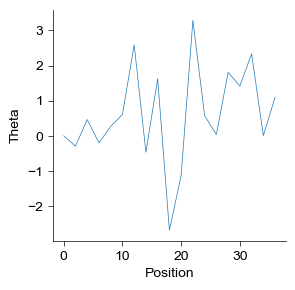

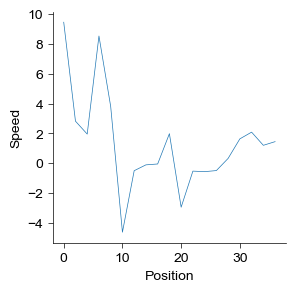

In [5]:
from sklearn.linear_model import LogisticRegression
def GLM_fitting(x, y):
    model = LogisticRegression(max_iter=200)
    model.fit(x.T, y)
    print(model.coef_, model.intercept_)
    return model.coef_[0]

if exists(join(figdata, f"{code_id} [Logit Regression].pkl")) == False:
    RegData = {
        "Position": [],
        "Type": [],
        "Theta": [],
        "Speed": [],
    }
    
    x, y = [[] for i in range(CP_DSP[6].shape[0])], [[] for i in range(CP_DSP[6].shape[0])]

    for mouse in [10212, 10224, 10227, 10232]:

        (
            behav_traj, 
            lap_traj, 
            route_traj, 
            session_traj, 
            pos_traj, 
            time_traj,
            speed_traj,
            len_traj,
            map_traj
        ) = get_lap_information(10232)

        idx = np.where(route_traj == 6)[0]

        behav_traj = behav_traj[:, idx]
        pos_traj = pos_traj[idx]
        map_traj = map_traj[idx]

        for i in range(0, CP_DSP[6].shape[0], 2):
            idx = np.where(np.isin(S2F[pos_traj], CP_DSP[6][i:i+2]))[0]

            x[i].append(behav_traj[:, idx])
            y[i].append(map_traj[idx])
    
    
    for i in tqdm(range(0, CP_DSP[6].shape[0], 2)):
        x[i] = np.concatenate(x[i], axis=1)
        y[i] = np.concatenate(y[i])
        
        params = GLM_fitting(x[i], y[i])
        
        RegData["Position"].append(i)
        RegData["Type"].append("Exp.")
        RegData["Theta"].append(params[3])
        RegData["Speed"].append(params[2])
        
    for key in RegData.keys():
        RegData[key] = np.asarray(RegData[key])
        
    with open(join(figdata, f"{code_id} [Logit Regression].pkl"), "wb") as f:
        pickle.dump(RegData, f)
        
    RegD = pd.DataFrame(RegData)
    RegD.to_excel(join(figdata, f"{code_id} [Logit Regression].xlsx"), index=False)

    print(len(RegD))
else:
    with open(join(figdata, f"{code_id} [Logit Regression].pkl"), 'rb') as handle:
        RegData = pickle.load(handle)
        
fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x="Position",
    y="Theta",
    data=RegData,
    linewidth=0.5,
    ax=ax
)
plt.show()

fig = plt.figure(figsize=(3, 3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x="Position",
    y="Speed",
    data=RegData,
    linewidth=0.5,
    ax=ax
)
plt.show()

In [ ]:
(
            behav_traj, 
            lap_traj, 
            route_traj, 
            session_traj, 
            pos_traj, 
            time_traj,
            speed_traj,
            len_traj,
            map_traj
) = get_lap_information(10232)

idx = np.where(route_traj == 6)[0]

behav_traj = behav_traj[:, idx]

# Neural Trajectory Analysis

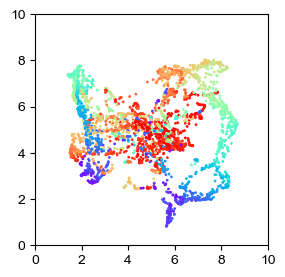

(0.0, 48.0, 48.0, 0.0)

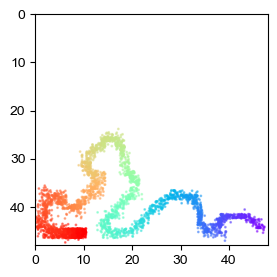

In [40]:
from sklearn.decomposition import PCA
from umap.umap_ import UMAP

mouse = 10227
(            
    neural_traj,
    session_traj,  
    route_traj, 
    lap_traj, 
    pos_traj, 
    speed_traj
) = get_data(mouse)

beg = np.concatenate([[0], np.where(np.ediff1d(lap_traj) != 0)[0]+1])
end = np.concatenate([np.where(np.ediff1d(lap_traj) != 0)[0]+1, [lap_traj.shape[0]]])
mean_kmean_dists, lap_labels = get_fate(mouse)

label_traj = np.zeros(lap_traj.shape[0], np.int64)
for i in range(beg.shape[0]):
    label_traj[beg[i]:end[i]] = lap_labels[i]

idx = np.where(route_traj == 6)[0]

neural_traj = neural_traj[:, idx]
lap_traj = lap_traj[idx]
session_traj = session_traj[idx]
pos_traj = pos_traj[idx]
route_traj = route_traj[idx]
speed_traj = speed_traj[idx]
label_traj = label_traj[idx]

pca = PCA(n_components=30)
denoised_data = pca.fit_transform(neural_traj.T)
umap_model = UMAP(n_components=3)
red_data = umap_model.fit_transform(denoised_data)

beg = np.concatenate([[0], np.where(np.ediff1d(lap_traj) != 0)[0]+1])
end = np.concatenate([np.where(np.ediff1d(lap_traj) != 0)[0]+1, [lap_traj.shape[0]]])

"""
for i in range(beg.shape[0]):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.plot(
        red_data[beg[i]:end[i], 0],
        red_data[beg[i]:end[i], 1],
        lw=1,
        c=RemappingPalette[int(label_traj[beg[i]])],
    )
    ax.axis([0, 10, 0, 10])
    ax.set_title(f"S{session_traj[beg[i]]} L{lap_traj[beg[i]]}")
    plt.show()
"""  

x, y = pos_traj % 48, pos_traj // 48
x = x.astype(np.float64) + np.random.rand(x.shape[0]) - 0.5
y = y.astype(np.float64) + np.random.rand(y.shape[0]) - 0.5
D = GetDMatrices(1, 48)
vmin, vmax = np.nanmin(D[pos_traj, 2303]), np.nanmax(D[pos_traj, 2303])

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(
    red_data[:, 0],
    red_data[:, 1],
    s=1,
    edgecolors=None,
    c=sns.color_palette("rainbow", as_cmap=True)((D[pos_traj, 2303] - vmin) /(vmax - vmin + 1e-8)),
)
ax.axis([0, 10, 0, 10])
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(
    x,
    y,
    s=1,
    edgecolors=None,
    c=sns.color_palette("rainbow", as_cmap=True)((D[pos_traj, 2303] - vmin) /(vmax - vmin + 1e-8)),
    alpha=0.5
)
ax.axis([0, 48, 48, 0])

# Behavioral Differences

In [23]:
from mylib.statistic_test import *

code_id = "0853 - Diverge of Route 7 Map"
loc = os.path.join(figpath, code_id)
mkdir(loc)

if exists(join(figdata, f"{code_id} [Lap Info].pkl")) == False:
    EffData = {
        "MiceID": [],
        "Session": [],
        "Is Perfect": [],
        "Lapwise Time": [],
        "Lapwise Distance": [],
    }
    
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        if exists(join(loc, f"{mouse}.pkl")) == False:
            X, session_label, route_label, kmeans_init = get_all_mice_data(mouse)
            
            with open(join(loc, f"{mouse}.pkl"), "wb") as f:
                pickle.dump([X, session_label, route_label, kmeans_init], f)
        else:
            with open(join(loc, f"{mouse}.pkl"), "rb") as f:
                X, session_label, route_label, kmeans_init = pickle.load(f)



        E:\Data\FinalResults\0853 - Diverge of Route 7 Map is already existed!
